Object Detection

We will be using Faster-RCNN ResNet-50 model in the form [n, c, h, w], where n is # images, c is # channels, h is height and w is width.
The model returns: 
    Bounding boxes [x0, y0, x1, y1] all all predicted classes of shape (N,4) where N is the number of classes predicted by the model to be present in the image.
    Labels of all predicted classes.
    Scores of each predicted label.


In [1]:
# import necessary libraries
from PIL import Image

import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import os
import subprocess
import requests
import glob

In [2]:
np.random.seed(20)

In [3]:
# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
)
model.eval()

# Class labels from official PyTorch documentation for the pretrained model
# Note that there are some N/A's
# for complete list check https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
# we will use the same list for this notebook
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

COLORS = np.random.uniform(0, 255, size=(len(COCO_INSTANCE_CATEGORY_NAMES), 3))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\rdinh/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [01:04<00:00, 2.61MB/s] 


In [4]:
def get_prediction(img_path, threshold):
    """
    Perform a forward pass through the model to make predictions.

    Parameters:
        img_path (str): Path to the input image.
        threshold (float): Minimum confidence score for filtering predictions.

    Returns:
        pred_boxes (list of tuples): Bounding box coordinates [(x1, y1), (x2, y2)].
        pred_class (list of str): Predicted class names for each bounding box.
    """

    # Open the image using PIL
    img = Image.open(img_path)

    # Convert the image to a PyTorch tensor
    transform = T.Compose([T.ToTensor()])
    img = transform(img)

    # Perform inference (forward pass)
    pred = model([img])

    # Extract predictions and detach them from the computation graph
    pred_data = pred[0]

    # Convert tensors to NumPy arrays
    labels = pred_data['labels'].detach().cpu().numpy()
    boxes = pred_data['boxes'].detach().cpu().numpy()
    scores = pred_data['scores'].detach().cpu().numpy()

    # Filter predictions based on threshold
    valid_indices = scores > threshold

    # Keep only valid bounding boxes and class labels
    pred_boxes = [((b[0], b[1]), (b[2], b[3])) for b in boxes[valid_indices]]
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in labels[valid_indices]]

    return pred_boxes, pred_class


In [5]:
def object_detection_api(
    img_path,
    threshold=0.5
):
    """
    Annotates the image with bounding boxes and class names.
    It calls the `get_prediction` function as well.
    parameters:
        img_path: path of the input image
        threshold: threshold value for prediction score
    method:
      - prediction is obtained from get_prediction method
      - for each prediction, bounding box is drawn and text is written
        with opencv
      - the final image is displayed
    """

    # Get predictions (bounding boxes and class labels) for the image
    boxes, pred_cls = get_prediction(img_path, threshold)

    # Read image using OpenCV
    img = cv2.imread(img_path)
    # Convert from OpenCV's default BGR format to RGB for correct visualization
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Calculate thickness for drawing bounding boxes based on image size
    rect_th = max(round(sum(img.shape) / 2 * 0.003), 2)
    # Calculate thickness for the text annotations
    text_th = max(rect_th - 1, 1)

    # Iterate through each detected object
    for i in range(len(boxes)):
        # Extract bounding box coordinates from the prediction output
        p1, p2 = (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1]))

        # Get color corresponding to the predicted class from a predefined color list
        color = COLORS[COCO_INSTANCE_CATEGORY_NAMES.index(pred_cls[i])]

        # Draw bounding box around the detected object
        cv2.rectangle(
            img,
            p1,  # Top-left corner
            p2,  # Bottom-right corner
            color=color,  # Bounding box color
            thickness=rect_th  # Line thickness
        )

        # Get the size (width and height) of the text to be displayed
        w, h = cv2.getTextSize(
            pred_cls[i],  # Object class name
            0,  # Font face
            fontScale=rect_th / 3,  # Scale font relative to box thickness
            thickness=text_th  # Text thickness
        )[0]  # Extract width and height

        # Determine if text label should be placed inside or outside the bounding box
        outside = p1[1] - h >= 3  # Check if there is enough space to put text above the box
        # Calculate coordinates for the background rectangle that holds the text
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3

        # Draw a filled rectangle for the class label background
        cv2.rectangle(
            img,
            p1,  # Top-left corner
            p2,  # Bottom-right corner
            color=color,  # Same as bounding box color
            thickness=-1,  # Filled rectangle
            lineType=cv2.LINE_AA  # Anti-aliased lines for smoother edges
        )

        # Overlay the text label on top of the filled rectangle
        cv2.putText(
            img,
            pred_cls[i],  # Class name
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),  # Adjust text position
            cv2.FONT_HERSHEY_SIMPLEX,  # Font type
            rect_th / 3,  # Scale font size
            (255, 255, 255),  # White text color
            thickness=text_th + 1  # Text thickness
        )

    # Create a figure for displaying the image
    plt.figure(figsize=(15,12))
    # Display the image with bounding boxes and labels
    plt.imshow(img)
    # Remove x-axis ticks for a cleaner visualization
    plt.xticks([])
    # Remove y-axis ticks for a cleaner visualization
    plt.yticks([])
    # Show the final output image
    plt.show()

In [6]:
# Helper function to download file.
def download_file(url, save_name):
    if not os.path.exists(save_name):
        subprocess.run(['wget', url, '-O', save_name, '-q'])

In [7]:
# Create directory to donwload inference data.
inference_dir = 'inference_data'
os.makedirs(inference_dir, exist_ok=True)

Person Detection

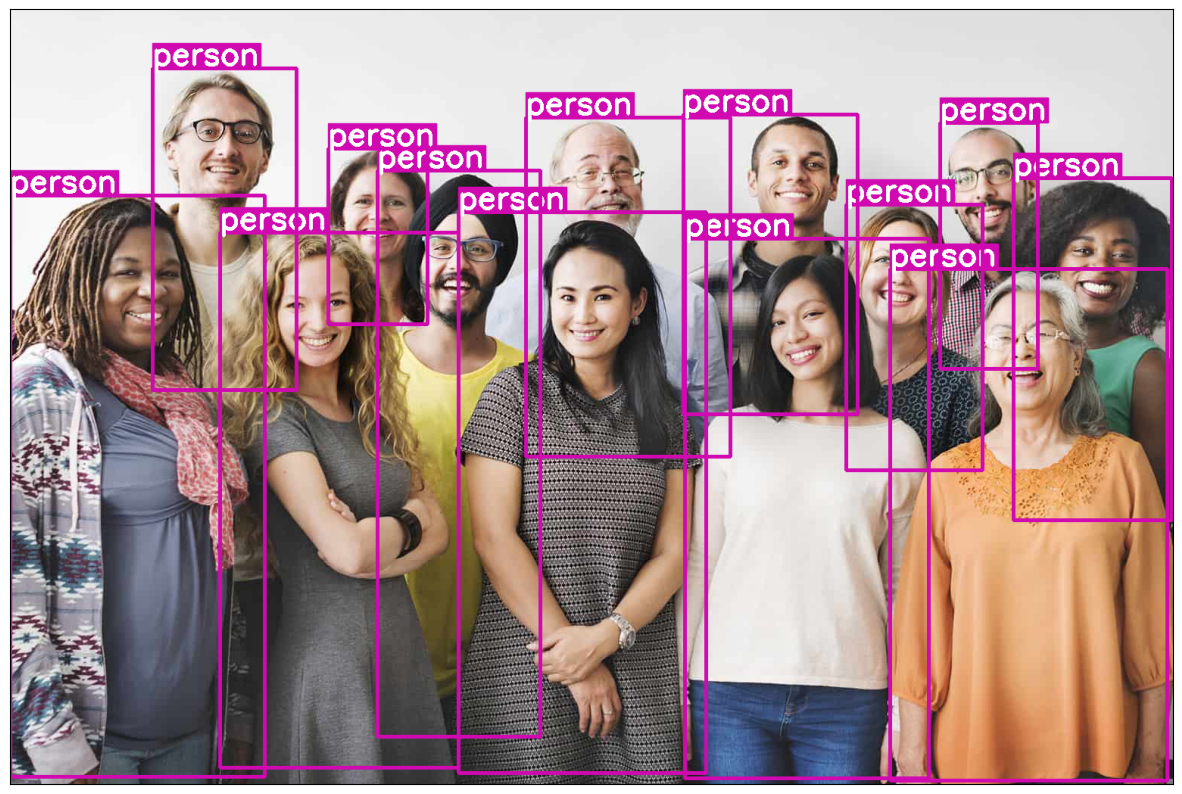

In [8]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/people.jpg',
    os.path.join(inference_dir, 'people.jpg')
)

# Use the api pipeline for object detection.
# The threshold is set manually, the model sometimes predicts
# andom structures as a potential object, so we set a threshold to keep objects
# with better prediction scores.
object_detection_api(os.path.join(inference_dir, 'people.jpg'), threshold=0.8)

Vehicle Detection

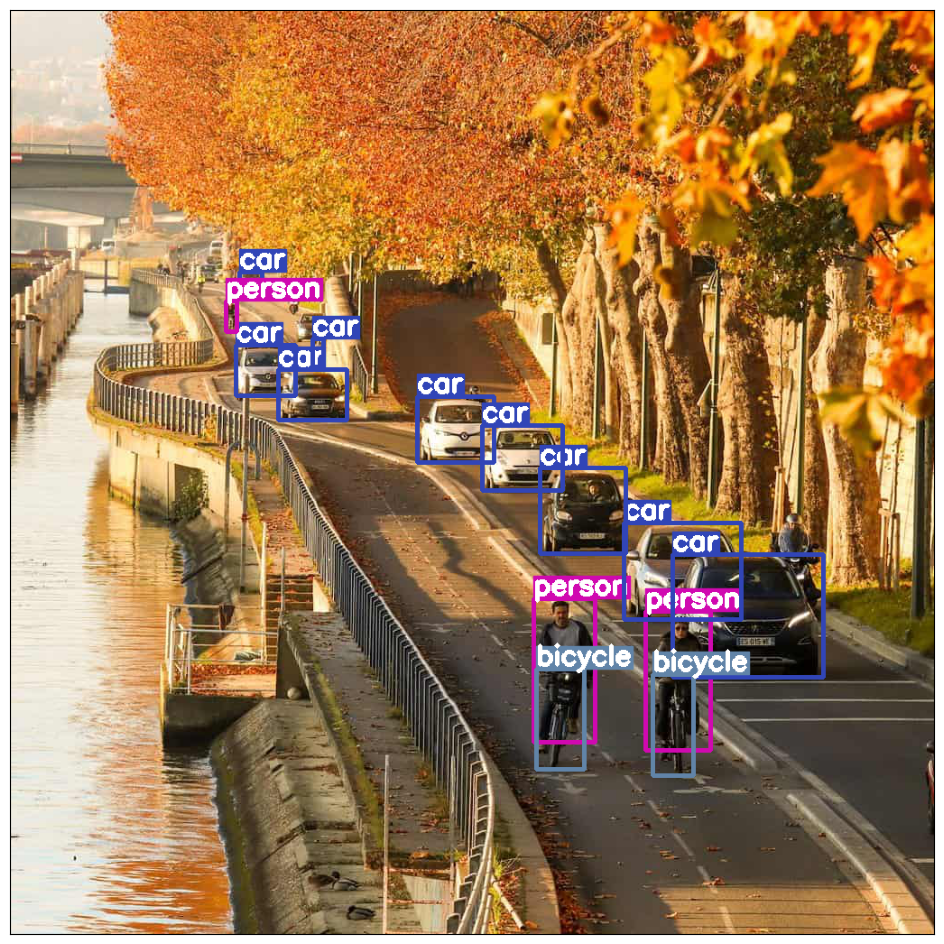

In [9]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/vehicles.jpg',
    os.path.join(inference_dir, 'vehicles.jpg')
)

object_detection_api(os.path.join(inference_dir, 'vehicles.jpg'), threshold=0.8)

Traffic Detection

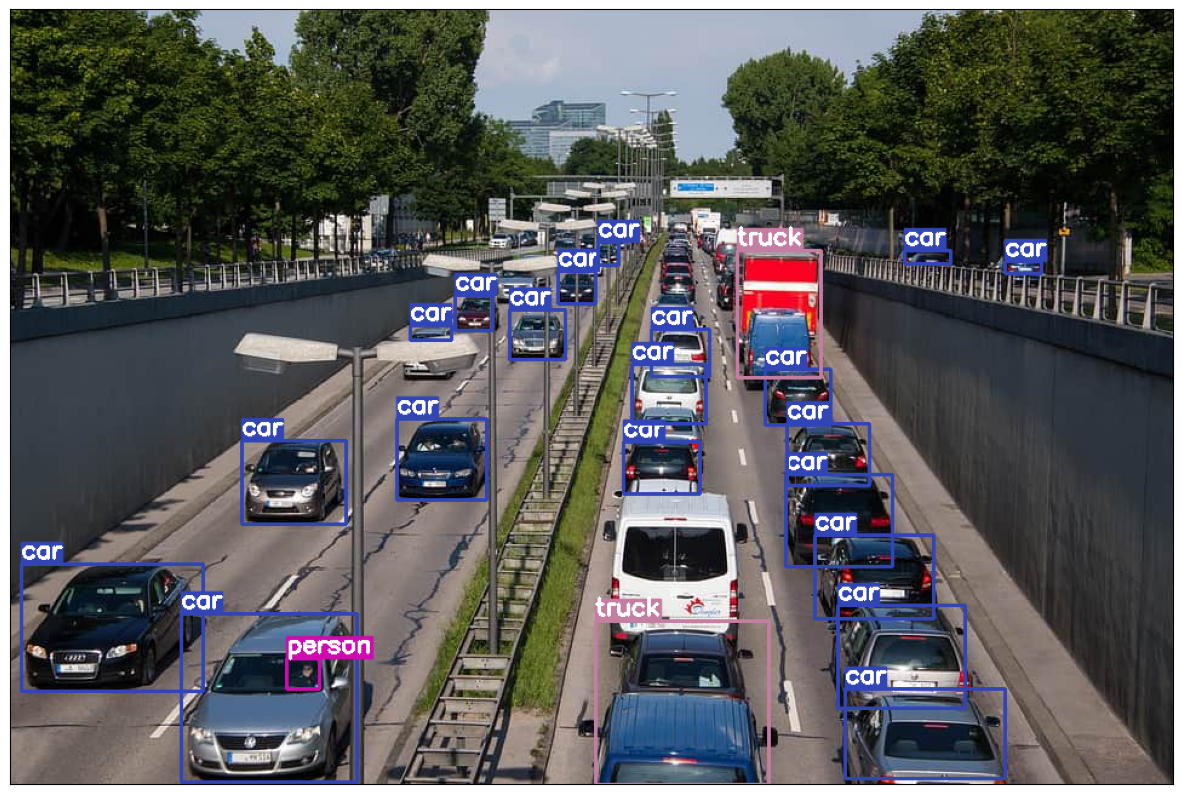

In [10]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/traffic_scene.jpg',
    os.path.join(inference_dir, 'traffic_scene.jpg')
)

object_detection_api(os.path.join(inference_dir, 'traffic_scene.jpg'), threshold=0.8)

Low Lighting Detection

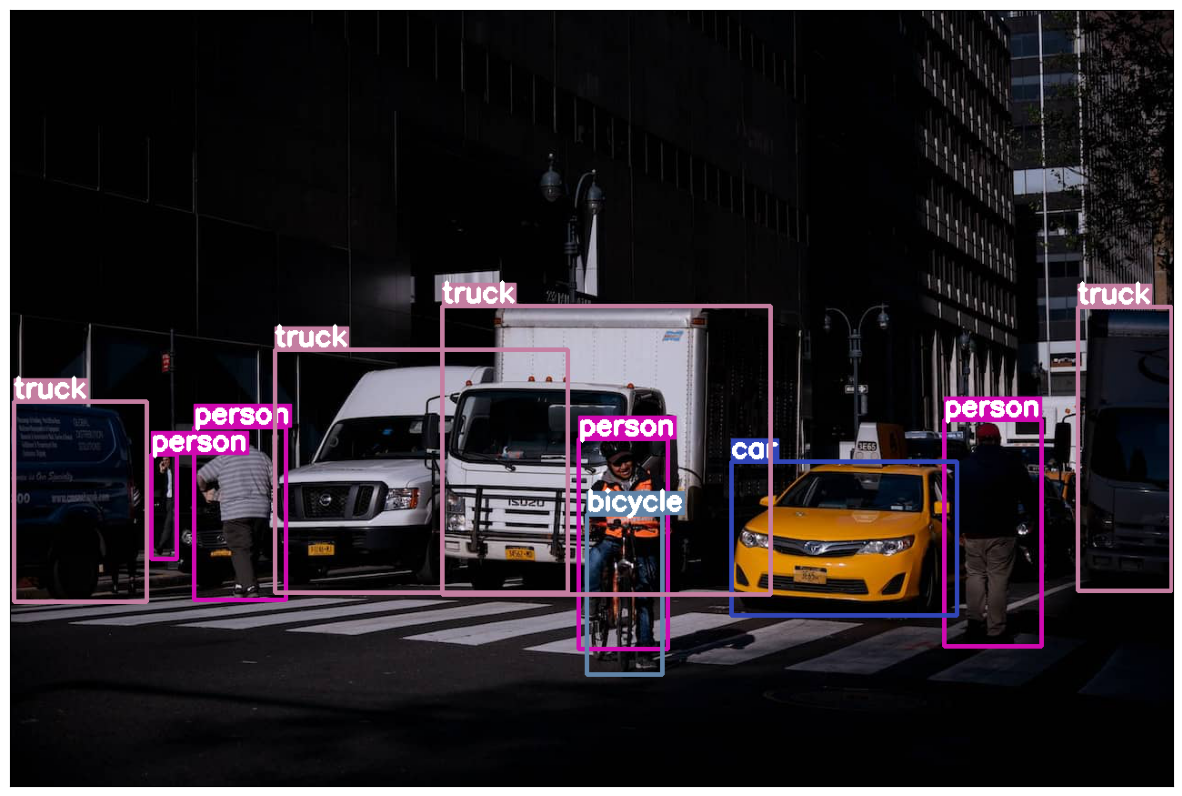

In [11]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/night-time.jpg',
    os.path.join(inference_dir, 'night-time.jpg')
)

object_detection_api(os.path.join(inference_dir, 'night-time.jpg'), threshold=0.8)

Crowded Object Detection

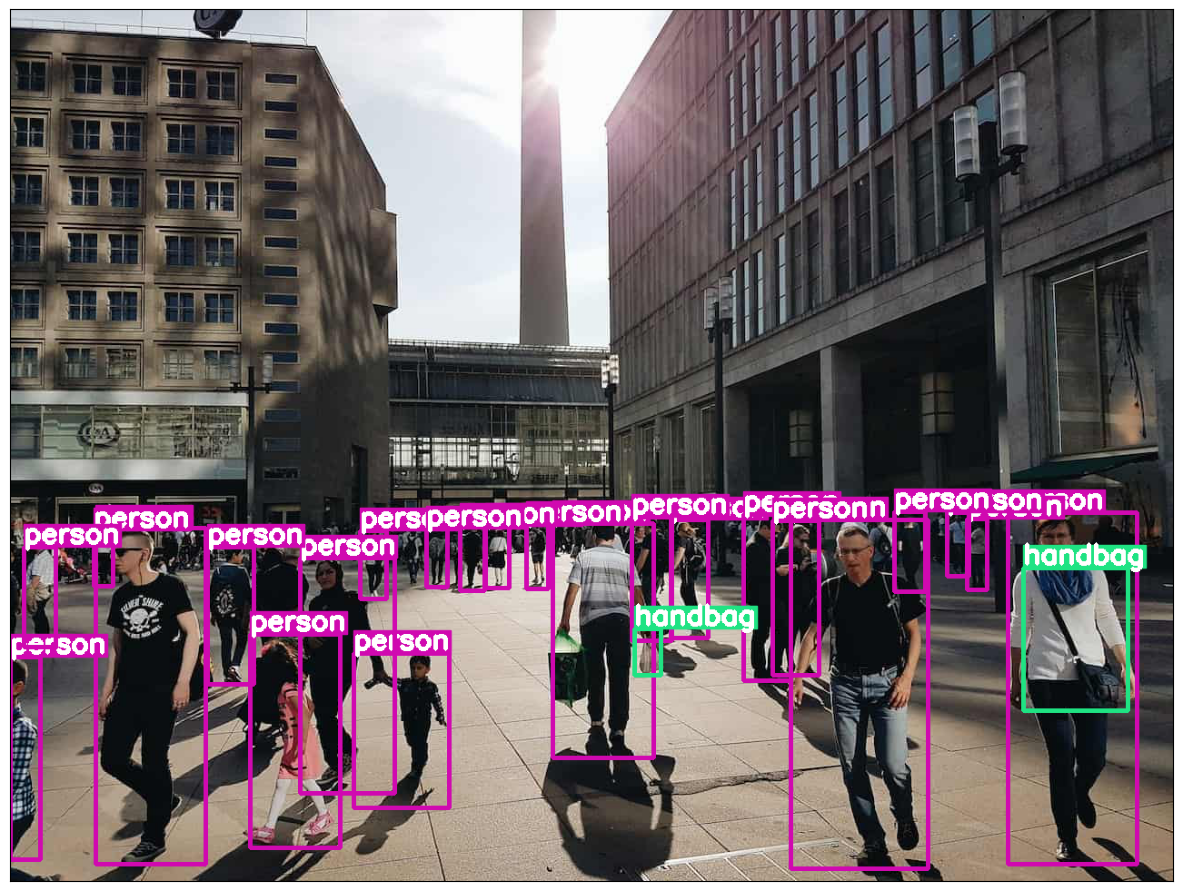

In [12]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/crowd.jpg',
    os.path.join(inference_dir, 'crowd.jpg')
)

object_detection_api(os.path.join(inference_dir, 'crowd.jpg'), threshold=0.8)